# Plotting a venn diagram for significant pathways extracted from the three models
- Using z-score, cut percentile method
- Parafac 1 on common pathways
- Parafac 2 on common pathways
- Parafac 2 on all pathways

In [1]:
import pickle
import matplotlib.pyplot as plt
from venn import venn
import sspa
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
import tensorly as tl
import pickle
from tensorly.decomposition import parafac2
import tlviz
import pathintegrate
from evaluation_metrics import degeneracy_score_adapted, df_rank_evaluation
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from pathway_feature_selection import bootstrap_feature_select_pr2, feature_select_bs_ci, significant_pathways, harmonic_pvalue,combined_pseudoz, significant_pseudoz, plot_zscore_distribution

In [2]:
with open('p1_f2_pseudoz_dict.pkl','rb') as f:
    p1_f2_pseudoz_dict = pickle.load(f)

with open('p1_f1_pseudoz_dict.pkl','rb') as f:
    p1_f1_pseudoz_dict = pickle.load(f)

with open('p1_sigpath_dict.pkl','rb') as f:
    p1_sigpath_dict = pickle.load(f) 

with open('parafac2_common_metab_sigpath_dict.pkl','rb') as f:
    parafac2_common_metab_sigpath_dict = pickle.load(f)

with open('parafac2_common_prot_sigpath_dict.pkl','rb') as f:
    parafac2_common_prot_sigpath_dict = pickle.load(f)

with open('parafac2_all_prot_sigpath_dict.pkl','rb') as f:
    parafac2_all_prot_sigpath_dict = pickle.load(f)

with open('parafac2_all_metab_sigpath_dict.pkl','rb') as f:
    parafac2_all_metab_sigpath_dict = pickle.load(f)

with open('common_pathways.pkl','rb') as f:
    common_pathways = pickle.load(f)

with open('metab_filtered_kpca.pkl','rb') as f:
    metab_filtered_kpca = pickle.load(f)

with open('prot_filtered_kpca.pkl','rb') as f:
    prot_filtered_kpca = pickle.load(f)

with open('abs_pseudoz_f2_dict.pkl','rb') as f:
    abs_pseudoz_f2_dict = pickle.load(f)

with open('mw_metab.pkl','rb') as f:
    mw_metab = pickle.load(f)

with open('mw_prot.pkl','rb') as f:
    mw_prot = pickle.load(f)

In [93]:
p1_sigpath_dict

{'R-HSA-8957322': 'Metabolism of steroids',
 'R-HSA-2980736': 'Peptide hormone metabolism',
 'R-HSA-381340': 'Transcriptional regulation of white adipocyte differentiation',
 'R-HSA-6806667': 'Metabolism of fat-soluble vitamins',
 'R-HSA-1643685': 'Disease',
 'R-HSA-168256': 'Immune System'}

In [96]:
p1_sigpath_df = pd.DataFrame.from_dict(p1_sigpath_dict,orient='index')

In [98]:
p1_sigpath_df.to_excel('/Users/yalilyu/desktop/sigpath.xlsx')

In [99]:
p2c_metab_sigpath_df = pd.DataFrame.from_dict(parafac2_common_metab_sigpath_dict,orient='index')
p2c_metab_sigpath_df.to_excel('/Users/yalilyu/desktop/p2c_metab.xlsx')

In [100]:
p2c_prot_sigpath_df = pd.DataFrame.from_dict(parafac2_common_prot_sigpath_dict,orient='index')
p2c_prot_sigpath_df.to_excel('/Users/yalilyu/desktop/p2c_prot.xlsx')

In [101]:
p2a_metab_sigpath_df = pd.DataFrame.from_dict(parafac2_all_metab_sigpath_dict,orient='index')
p2a_metab_sigpath_df.to_excel('/Users/yalilyu/desktop/p2a_metab.xlsx')

In [102]:
p2a_prot_sigpath_df = pd.DataFrame.from_dict(parafac2_all_prot_sigpath_dict,orient='index')
p2a_prot_sigpath_df.to_excel('/Users/yalilyu/desktop/p2a_prot.xlsx')

In [3]:
parafac1_sig_path_set = set(p1_sigpath_dict.keys())

In [4]:
parafac2_common_metab_sigpath_set = set(parafac2_common_metab_sigpath_dict.keys())

In [5]:
parafac2_common_prot_sigpath_set = set(parafac2_common_prot_sigpath_dict.keys())

In [6]:
p2_common = parafac2_common_metab_sigpath_set.union(parafac2_common_prot_sigpath_set)

In [7]:
parafac2_all_prot_sigpath_set = set(parafac2_all_prot_sigpath_dict.keys())

In [8]:
parafac2_all_metab_sigpath_set = set(parafac2_all_metab_sigpath_dict.keys())

In [9]:
p2_all = parafac2_all_prot_sigpath_set.union(parafac2_all_metab_sigpath_set)

In [10]:
all_sig = parafac1_sig_path_set | p2_common | p2_all

In [11]:
mw_metab_sig = mw_metab[mw_metab.index.isin(all_sig)]

In [12]:
mw_metab_sig.index

Index(['R-HSA-109582', 'R-HSA-1266738', 'R-HSA-140179', 'R-HSA-1483206',
       'R-HSA-1483257', 'R-HSA-15869', 'R-HSA-162582', 'R-HSA-1643685',
       'R-HSA-1660661', 'R-HSA-168249', 'R-HSA-168256', 'R-HSA-194138',
       'R-HSA-196854', 'R-HSA-2980736', 'R-HSA-381340', 'R-HSA-388396',
       'R-HSA-392499', 'R-HSA-428157', 'R-HSA-4420097', 'R-HSA-442660',
       'R-HSA-549127', 'R-HSA-549132', 'R-HSA-597592', 'R-HSA-6806667',
       'R-HSA-73894', 'R-HSA-8939211', 'R-HSA-8957322', 'R-HSA-9006931',
       'R-HSA-9006934', 'R-HSA-9009391'],
      dtype='object')

In [28]:
inp1=0
inp2_common=0
inp2_all = 0
for path in mw_metab_sig[mw_metab_sig['p_val']>0.05].index:
    if path in p1_sigpath_dict.keys():
        inp1 +=1
    elif path in p2_common:
        inp2_common+=1
        print(f"in p2_common:{path}")
    else:
        inp2_all +=1
        print(f"inp2_all: {path}")
print(inp1,inp2_common,inp2_all)

inp2_all: R-HSA-15869
in p2_common:R-HSA-9006934
0 1 1


In [13]:
mw_prot_sig = mw_prot[mw_prot.index.isin(all_sig)]

In [14]:
mw_prot_sig.index

Index(['R-HSA-1280218', 'R-HSA-109581', 'R-HSA-9664424', 'R-HSA-5693532',
       'R-HSA-73894', 'R-HSA-73887', 'R-HSA-1266738', 'R-HSA-1643685',
       'R-HSA-5663202', 'R-HSA-199977', 'R-HSA-8939211', 'R-HSA-9009391',
       'R-HSA-6809371', 'R-HSA-388396', 'R-HSA-109582', 'R-HSA-5693538',
       'R-HSA-168256', 'R-HSA-168255', 'R-HSA-168249', 'R-HSA-9012546',
       'R-HSA-6785807', 'R-HSA-6805567', 'R-HSA-165159', 'R-HSA-6806667',
       'R-HSA-15869', 'R-HSA-392499', 'R-HSA-8957322', 'R-HSA-196854',
       'R-HSA-168638', 'R-HSA-168643', 'R-HSA-389948', 'R-HSA-2980736',
       'R-HSA-597592', 'R-HSA-9679191', 'R-HSA-5357801', 'R-HSA-9660826',
       'R-HSA-9679506', 'R-HSA-9678108', 'R-HSA-162582', 'R-HSA-9006931',
       'R-HSA-9006934', 'R-HSA-194138', 'R-HSA-428157', 'R-HSA-5633008',
       'R-HSA-75158', 'R-HSA-166016', 'R-HSA-381340', 'R-HSA-4420097'],
      dtype='object')

In [15]:
mw_prot_sig[mw_prot_sig['p_val']>0.05]

,p_val
R-HSA-5693532,0.22397
R-HSA-5693538,0.22397
R-HSA-168255,0.22397


In [16]:
for path in mw_prot_sig[mw_prot_sig['p_val']>0.05].index:
    if path in common_pathways:
        print(path)

In [17]:
inp1=0
inp2_common=0
inp2_all = 0
for path in mw_prot_sig[mw_prot_sig['p_val']>0.05].index:
    if path in p1_sigpath_dict.keys():
        inp1 +=1
    elif path in p2_common:
        inp2_common+=1
        print(f"in p2_common:{path}")
    else:
        inp2_all +=1
        print(f"inp2_all: {path}")
print(inp1,inp2_common,inp2_all)

inp2_all: R-HSA-5693532
inp2_all: R-HSA-5693538
inp2_all: R-HSA-168255
0 0 3


In [18]:
inp2_all_metab = 0
inp2_all_prot = 0
inp2_common_metab = 0
inp2_common_prot = 0
for path in mw_prot_sig[mw_prot_sig['p_val']>0.05].index:
    if path in parafac2_all_metab_sigpath_dict.keys():
        inp2_all_metab +=1
    elif path in parafac2_all_prot_sigpath_set:
        inp2_all_prot +=1
    elif path in parafac2_common_metab_sigpath_dict.keys():
        inp2_common_metab +=1
    else: 
        inp2_common_prot +=1
print(inp2_all_metab,inp2_all_prot,inp2_common_metab,inp2_common_prot)

0 3 0 0


In [19]:
for path in mw_metab_sig[mw_metab_sig['p_val']>0.05].index:
    if path in common_pathways:
        print(path)

R-HSA-15869
R-HSA-9006934


In [20]:
mw_prot_sig.loc['R-HSA-9006934']

p_val    4.717529e-39
Name: R-HSA-9006934, dtype: float64

In [21]:
mw_metab_sig[mw_metab_sig['p_val']>0.05]

,p_val
R-HSA-15869,0.128497
R-HSA-9006934,0.543183


In [22]:
inp1=0
inp2_common=0
inp2_all = 0
for path in mw_metab_sig[mw_metab_sig['p_val']>0.05].index:
    if path in p1_sigpath_dict.keys():
        inp1 +=1
    elif path in p2_common:
        inp2_common+=1
    else:
        inp2_all +=1
print(inp1,inp2_common,inp2_all)

0 1 1


In [23]:
inmetab = 0
inprot = 0
for path in mw_metab_sig[mw_metab_sig['p_val']>0.05].index:
    if path in parafac2_all_metab_sigpath_dict.keys():
        inmetab +=1
    else:
        inprot +=1
print(inmetab,inprot)

1 1


In [24]:
for path in mw_metab_sig[mw_metab_sig['p_val']>0.05].index:
    if path in common_pathways:
        print(path)

R-HSA-15869
R-HSA-9006934


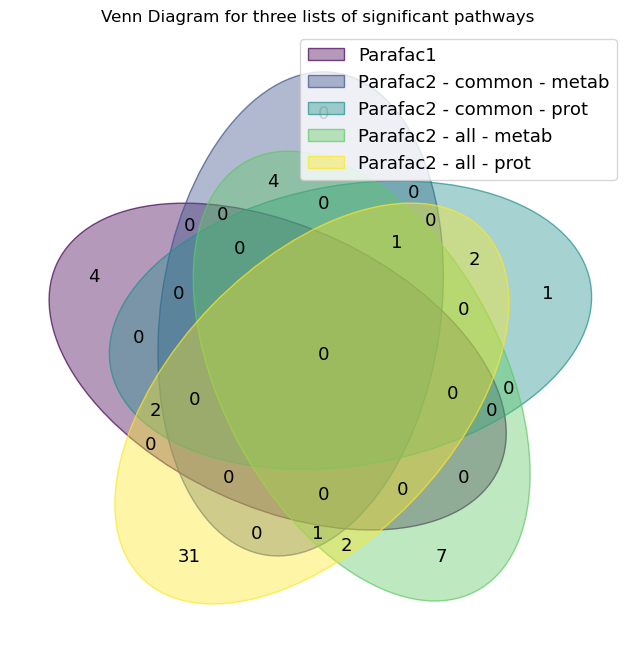

In [25]:
venn({
    'Parafac1': parafac1_sig_path_set,
    'Parafac2 - common - metab': parafac2_common_metab_sigpath_set,
    'Parafac2 - common - prot':parafac2_common_prot_sigpath_set,
    'Parafac2 - all - metab': parafac2_all_metab_sigpath_set,
    'Parafac2 - all - prot': parafac2_all_prot_sigpath_set
})

plt.title("Venn Diagram for three lists of significant pathways")
plt.show()

In [40]:
overlapped_all_id = parafac1_sig_path_set.intersection(p2_common).intersection(p2_all)
overlapped_all_dict = {}
for pathway_id, pathway_name in p1_sigpath_dict.items():
    if pathway_id in overlapped_all_id:
        overlapped_all_dict[pathway_id]=pathway_name

overlapped_all_dict

{'R-HSA-1643685': 'Disease', 'R-HSA-168256': 'Immune System'}

In [44]:
# investigating pathways that are unique to parafac1
unique_to_pr1_id = parafac1_sig_path_set - p2_common - p2_all
unique_to_pr1_dict = {}
for pathway_id, pathway_name in p1_sigpath_dict.items():
    if pathway_id in unique_to_pr1_id:
        unique_to_pr1_dict[pathway_id]=pathway_name

unique_to_pr1_dict

{'R-HSA-8957322': 'Metabolism of steroids',
 'R-HSA-2980736': 'Peptide hormone metabolism',
 'R-HSA-381340': 'Transcriptional regulation of white adipocyte differentiation',
 'R-HSA-6806667': 'Metabolism of fat-soluble vitamins'}

In [45]:
# Pathways unique to parafac2 common
unique_to_pr2_common_id = p2_common - parafac1_sig_path_set - p2_all
unique_to_pr2_common_dict = {}
for pathway_id, pathway_name in parafac2_common_metab_sigpath_dict.items():
    if pathway_id in unique_to_pr2_common_id:
        unique_to_pr2_common_dict[pathway_id]=pathway_name

for pathway_id, pathway_name in parafac2_common_prot_sigpath_dict.items():
    if pathway_id in unique_to_pr2_common_id:
        unique_to_pr2_common_dict[pathway_id]=pathway_name

unique_to_pr2_common_dict

{'R-HSA-196854': 'Metabolism of vitamins and cofactors'}

In [58]:
p2_all_dict = parafac2_all_prot_sigpath_dict.copy()
p2_all_dict.update(parafac2_all_metab_sigpath_dict)

In [60]:
# Pathways unique to parafac2 all
unique_to_pr2_all_id = p2_all - p2_common - parafac1_sig_path_set 
unique_to_pr2_all_dict = {}
for pathway_id, pathway_name in p2_all_dict.items():
    if pathway_id in unique_to_pr2_all_id:
        unique_to_pr2_all_dict[pathway_id]=pathway_name

unique_to_pr2_all_dict

{'R-HSA-73887': 'Death Receptor Signaling',
 'R-HSA-597592': 'Post-translational protein modification',
 'R-HSA-168249': 'Innate Immune System',
 'R-HSA-162582': 'Signal Transduction',
 'R-HSA-1280218': 'Adaptive Immune System',
 'R-HSA-1266738': 'Developmental Biology',
 'R-HSA-5357801': 'Programmed Cell Death',
 'R-HSA-168643': 'Nucleotide-binding domain, leucine rich repeat containing receptor (NLR) signaling pathways',
 'R-HSA-5663202': 'Diseases of signal transduction by growth factor receptors and second messengers',
 'R-HSA-392499': 'Metabolism of proteins',
 'R-HSA-199977': 'ER to Golgi Anterograde Transport',
 'R-HSA-9679506': 'SARS-CoV Infections',
 'R-HSA-109581': 'Apoptosis',
 'R-HSA-165159': 'MTOR signalling',
 'R-HSA-168638': 'NOD1/2 Signaling Pathway',
 'R-HSA-166016': 'Toll Like Receptor 4 (TLR4) Cascade',
 'R-HSA-75158': 'TRAIL  signaling',
 'R-HSA-5633008': 'TP53 Regulates Transcription of Cell Death Genes',
 'R-HSA-15869': 'Metabolism of nucleotides',
 'R-HSA-389948'

In [61]:
# Extract significant pathways that are unique to parafac2 (all) model but present in common_pathways
common_but_unique_dict = {}
for pathway_id, pathway_name in unique_to_pr2_all_dict.items():
    if pathway_id in common_pathways:
        common_but_unique_dict[pathway_id]=pathway_name
common_but_unique_dict

{'R-HSA-597592': 'Post-translational protein modification',
 'R-HSA-168249': 'Innate Immune System',
 'R-HSA-162582': 'Signal Transduction',
 'R-HSA-1266738': 'Developmental Biology',
 'R-HSA-392499': 'Metabolism of proteins',
 'R-HSA-15869': 'Metabolism of nucleotides',
 'R-HSA-194138': 'Signaling by VEGF',
 'R-HSA-4420097': 'VEGFA-VEGFR2 Pathway'}

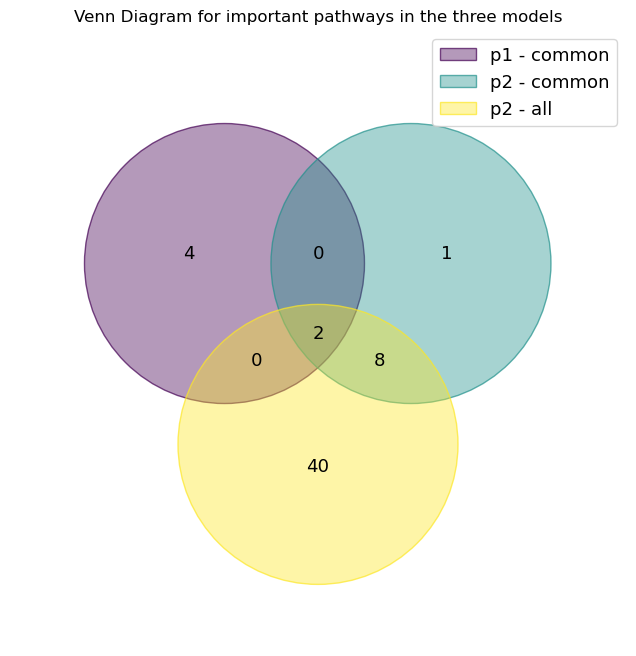

In [27]:
venn({
    'p1 - common': parafac1_sig_path_set,
    'p2 - common': p2_common,
    'p2 - all': p2_all
})

plt.title("Venn Diagram for important pathways in the three models")
plt.show()

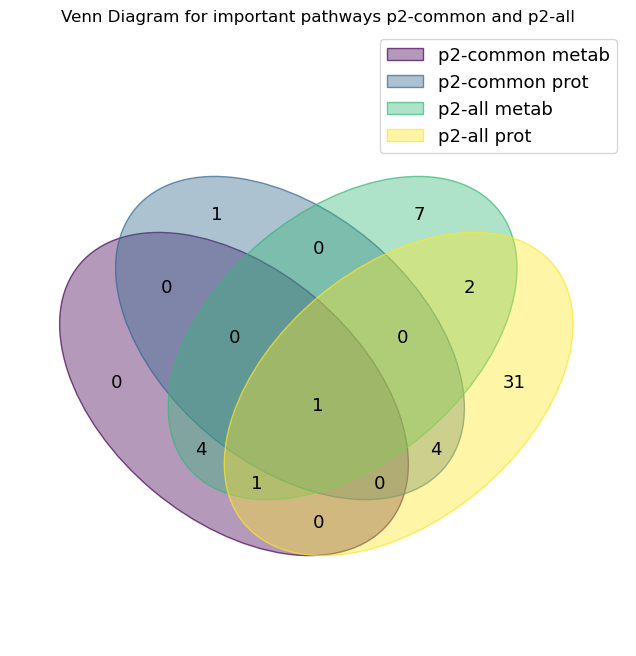

In [46]:
venn({
    'p2-common metab': parafac2_common_metab_sigpath_set,
    'p2-common prot': parafac2_common_prot_sigpath_set,    
    'p2-all metab':parafac2_all_metab_sigpath_set,
    'p2-all prot':parafac2_all_prot_sigpath_set
})

plt.title("Venn Diagram for important pathways p2-common and p2-all")
plt.show()

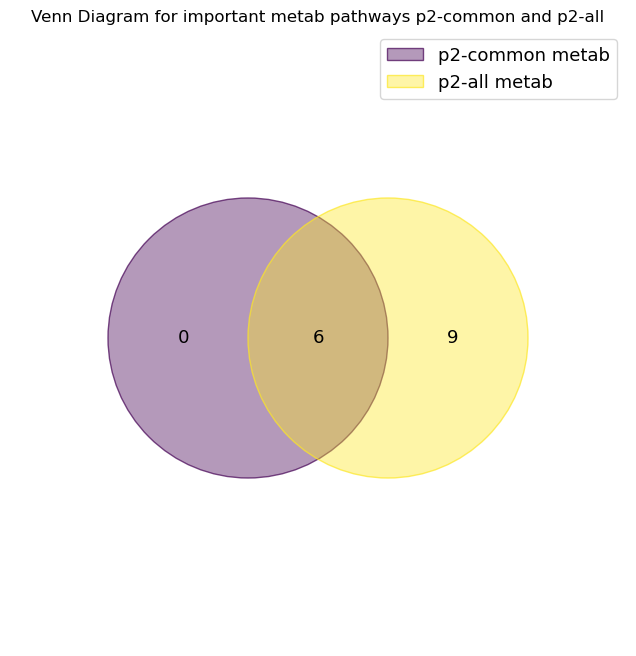

In [47]:
venn({
    'p2-common metab': parafac2_common_metab_sigpath_set,
    'p2-all metab':parafac2_all_metab_sigpath_set
})

plt.title("Venn Diagram for important metab pathways p2-common and p2-all")
plt.show()

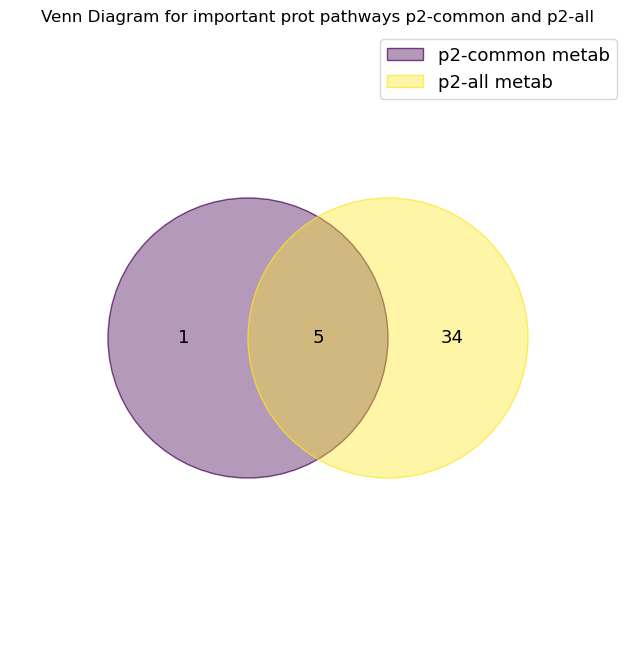

In [48]:
venn({
    'p2-common metab': parafac2_common_prot_sigpath_set,
    'p2-all metab':parafac2_all_prot_sigpath_set
})

plt.title("Venn Diagram for important prot pathways p2-common and p2-all")
plt.show()

In [30]:
with open('reactome_updated.pkl','rb') as f:
    prot_pathways = pickle.load(f)

In [32]:
prot_pathway_dict = dict(zip(prot_pathways.index,prot_pathways['Pathway_name'].to_list()))

In [33]:
metab_pathways  = sspa.process_reactome(organism="Homo sapiens")
metab_pathway_dict = dict(zip(metab_pathways.index,metab_pathways['Pathway_name'].to_list()))

In [35]:
all_sig_list = list(all_sig)

In [37]:
all_sig_dict = {
    sig: metab_pathway_dict[sig] for sig in all_sig_list if sig in metab_pathway_dict
} | {
    sig: prot_pathway_dict[sig] for sig in all_sig_list if sig in prot_pathway_dict
}

In [39]:
all_sig_dict

{'R-HSA-5357801': 'Programmed Cell Death',
 'R-HSA-381340': 'Transcriptional regulation of white adipocyte differentiation',
 'R-HSA-8957322': 'Metabolism of steroids',
 'R-HSA-166016': 'Toll Like Receptor 4 (TLR4) Cascade',
 'R-HSA-9664424': 'Cell recruitment (pro-inflammatory response)',
 'R-HSA-168638': 'NOD1/2 Signaling Pathway',
 'R-HSA-388396': 'GPCR downstream signalling',
 'R-HSA-6785807': 'Interleukin-4 and Interleukin-13 signaling',
 'R-HSA-168255': 'Influenza Infection',
 'R-HSA-73887': 'Death Receptor Signaling',
 'R-HSA-5693532': 'DNA Double-Strand Break Repair',
 'R-HSA-392499': 'Metabolism of proteins',
 'R-HSA-1660661': 'Sphingolipid de novo biosynthesis',
 'R-HSA-165159': 'MTOR signalling',
 'R-HSA-5633008': 'TP53 Regulates Transcription of Cell Death Genes',
 'R-HSA-9006931': 'Signaling by Nuclear Receptors',
 'R-HSA-168249': 'Innate Immune System',
 'R-HSA-1643685': 'Disease',
 'R-HSA-4420097': 'VEGFA-VEGFR2 Pathway',
 'R-HSA-9679191': 'Potential therapeutics for SAR

In [50]:
parafac2_all_metab_sigpath_dict

{'R-HSA-9009391': 'Extra-nuclear estrogen signaling',
 'R-HSA-9006931': 'Signaling by Nuclear Receptors',
 'R-HSA-8939211': 'ESR-mediated signaling',
 'R-HSA-4420097': 'VEGFA-VEGFR2 Pathway',
 'R-HSA-194138': 'Signaling by VEGF',
 'R-HSA-9006934': 'Signaling by Receptor Tyrosine Kinases',
 'R-HSA-1660661': 'Sphingolipid de novo biosynthesis',
 'R-HSA-428157': 'Sphingolipid metabolism',
 'R-HSA-1483257': 'Phospholipid metabolism',
 'R-HSA-1483206': 'Glycerophospholipid biosynthesis',
 'R-HSA-140179': 'Amine Oxidase reactions',
 'R-HSA-549132': 'Organic cation/anion/zwitterion transport',
 'R-HSA-442660': 'Na+/Cl- dependent neurotransmitter transporters',
 'R-HSA-549127': 'Organic cation transport',
 'R-HSA-109582': 'Hemostasis'}

In [64]:
len(all_sig_list)

55

In [83]:
mw_metab=mw_metab.sort_values(by='p_val',ascending=True)

In [85]:
mw_metab['index']=range(1,150)

In [87]:
mw_metab.loc[mw_metab.index.isin(all_sig_list)]

,p_val,index
R-HSA-442660,9.135948e-82,1
R-HSA-1483206,5.369285e-65,22
R-HSA-1483257,2.704644e-56,30
R-HSA-162582,3.458714e-50,35
R-HSA-1643685,3.113905e-48,37
R-HSA-388396,1.932176e-44,44
R-HSA-109582,4.717529e-39,57
R-HSA-8957322,1.158663e-35,63
R-HSA-2980736,7.162402e-31,70
R-HSA-140179,7.055719e-28,74


In [89]:
mw_prot=mw_prot.sort_values(by='p_val',ascending=True)

In [90]:
mw_prot['index']=range(1,387)

In [91]:
mw_prot.loc[mw_prot.index.isin(all_sig_list)]

,p_val,index
R-HSA-5633008,9.135948e-82,3
R-HSA-6809371,2.995133e-79,5
R-HSA-6805567,2.995133e-79,8
R-HSA-6785807,8.954674e-77,19
R-HSA-9660826,8.954674e-77,20
R-HSA-9664424,8.954674e-77,21
R-HSA-9009391,8.954674e-77,22
R-HSA-75158,2.441508e-74,25
R-HSA-8957322,6.070784e-72,29
R-HSA-165159,2.846884e-67,35
